<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/red_wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red wine quality classification

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'uciml/red-wine-quality-cortez-et-al-2009'

Saving kaggle.json to kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 37.1MB/s]


In [ ]:
%%bash
mkdir -p /content/data
unzip /content/red-wine-quality-cortez-et-al-2009.zip -d /content/data/

Archive:  /content/red-wine-quality-cortez-et-al-2009.zip
  inflating: /content/data/winequality-red.csv  


In [ ]:
import pandas as pd

data = pd.read_csv('/content/data/winequality-red.csv')

In [ ]:
data.shape

(1599, 12)

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop("quality", axis=1)
y = data["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Data exploration

In [ ]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
379,8.3,0.42,0.38,2.5,0.094,24.0,60.0,0.99790,3.31,0.70,10.8
321,9.3,0.61,0.26,3.4,0.090,25.0,87.0,0.99975,3.24,0.62,9.7
1413,9.9,0.57,0.25,2.0,0.104,12.0,89.0,0.99630,3.04,0.90,10.1
1157,5.1,0.51,0.18,2.1,0.042,16.0,101.0,0.99240,3.46,0.87,12.9
471,9.6,0.54,0.42,2.4,0.081,25.0,52.0,0.99700,3.20,0.71,11.4


In [ ]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.348866,0.528933,0.272314,2.571697,0.087389,15.708366,46.399140,0.996795,3.309335,0.660063,10.413552
std,1.745510,0.182456,0.195654,1.463399,0.046112,10.405256,33.022109,0.001905,0.156055,0.170387,1.063108
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.370000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995660,3.210000,0.550000,9.500000
50%,8.000000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996800,3.310000,0.620000,10.200000
75%,9.300000,0.640000,0.430000,2.600000,0.091000,21.000000,62.000000,0.997900,3.400000,0.730000,11.100000
max,15.900000,1.580000,0.790000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,1.980000,14.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


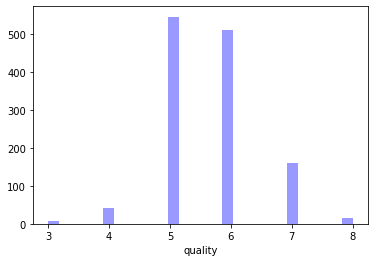

In [ ]:
import seaborn as sns

sns.distplot(y_train, kde=False, color='blue')


In [ ]:
y_train.value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [ ]:
combined = pd.concat([X_train, y_train], axis=1)

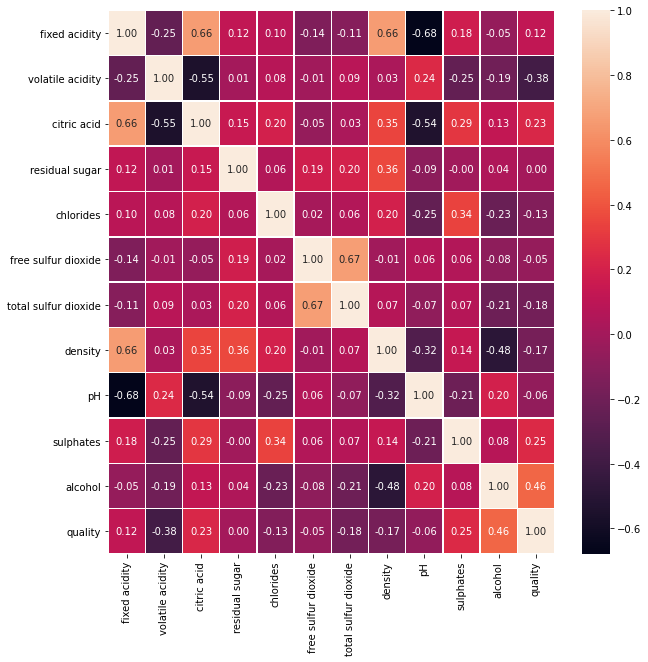

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize = (10,10))

sns.heatmap(combined.corr(), annot = True, linewidths=.5, fmt = ".2f", ax=axes)
plt.show()

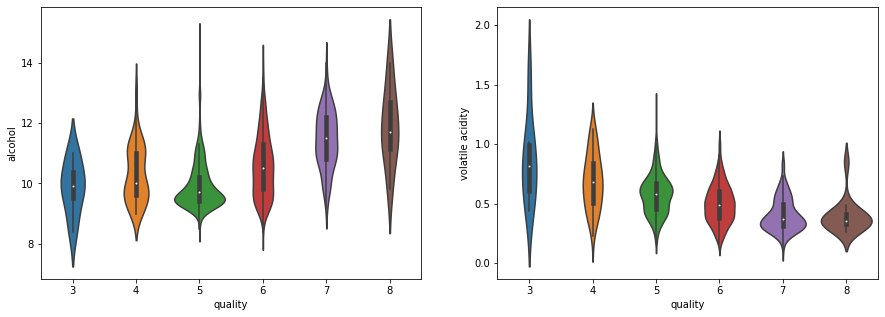

In [ ]:
fig, axes = plt.subplots(1, 2, figsize =(15,5))

def violin(feature, ax):
  sns.violinplot(x='quality',
                 y=feature,
                 sizes=(10, 200),
                 data=combined,
                 ax=ax)

violin('alcohol', axes[0])
violin('volatile acidity', axes[1])

Since standard coefficient correlation captures only linear correlations, plot the pairs to detect nonlinear correlations.


In [ ]:
combined['quality'].value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [ ]:
x = combined.groupby(pd.cut(combined['quality'], bins=[1, 3, 7, 10]))
bin_keys = x.groups.keys()
labels = { 1: 'Bad', 2: 'Mediocre', 3: 'Good' }

tmp = combined.copy()
for i, b in enumerate(bin_keys, 1):
  idx = x.groups.get(b)
  tmp.loc[idx, 'quality'] = labels[i]

tmp.head()
tmp['quality'].value_counts()

Mediocre    1256
Good          15
Bad            8
Name: quality, dtype: int64

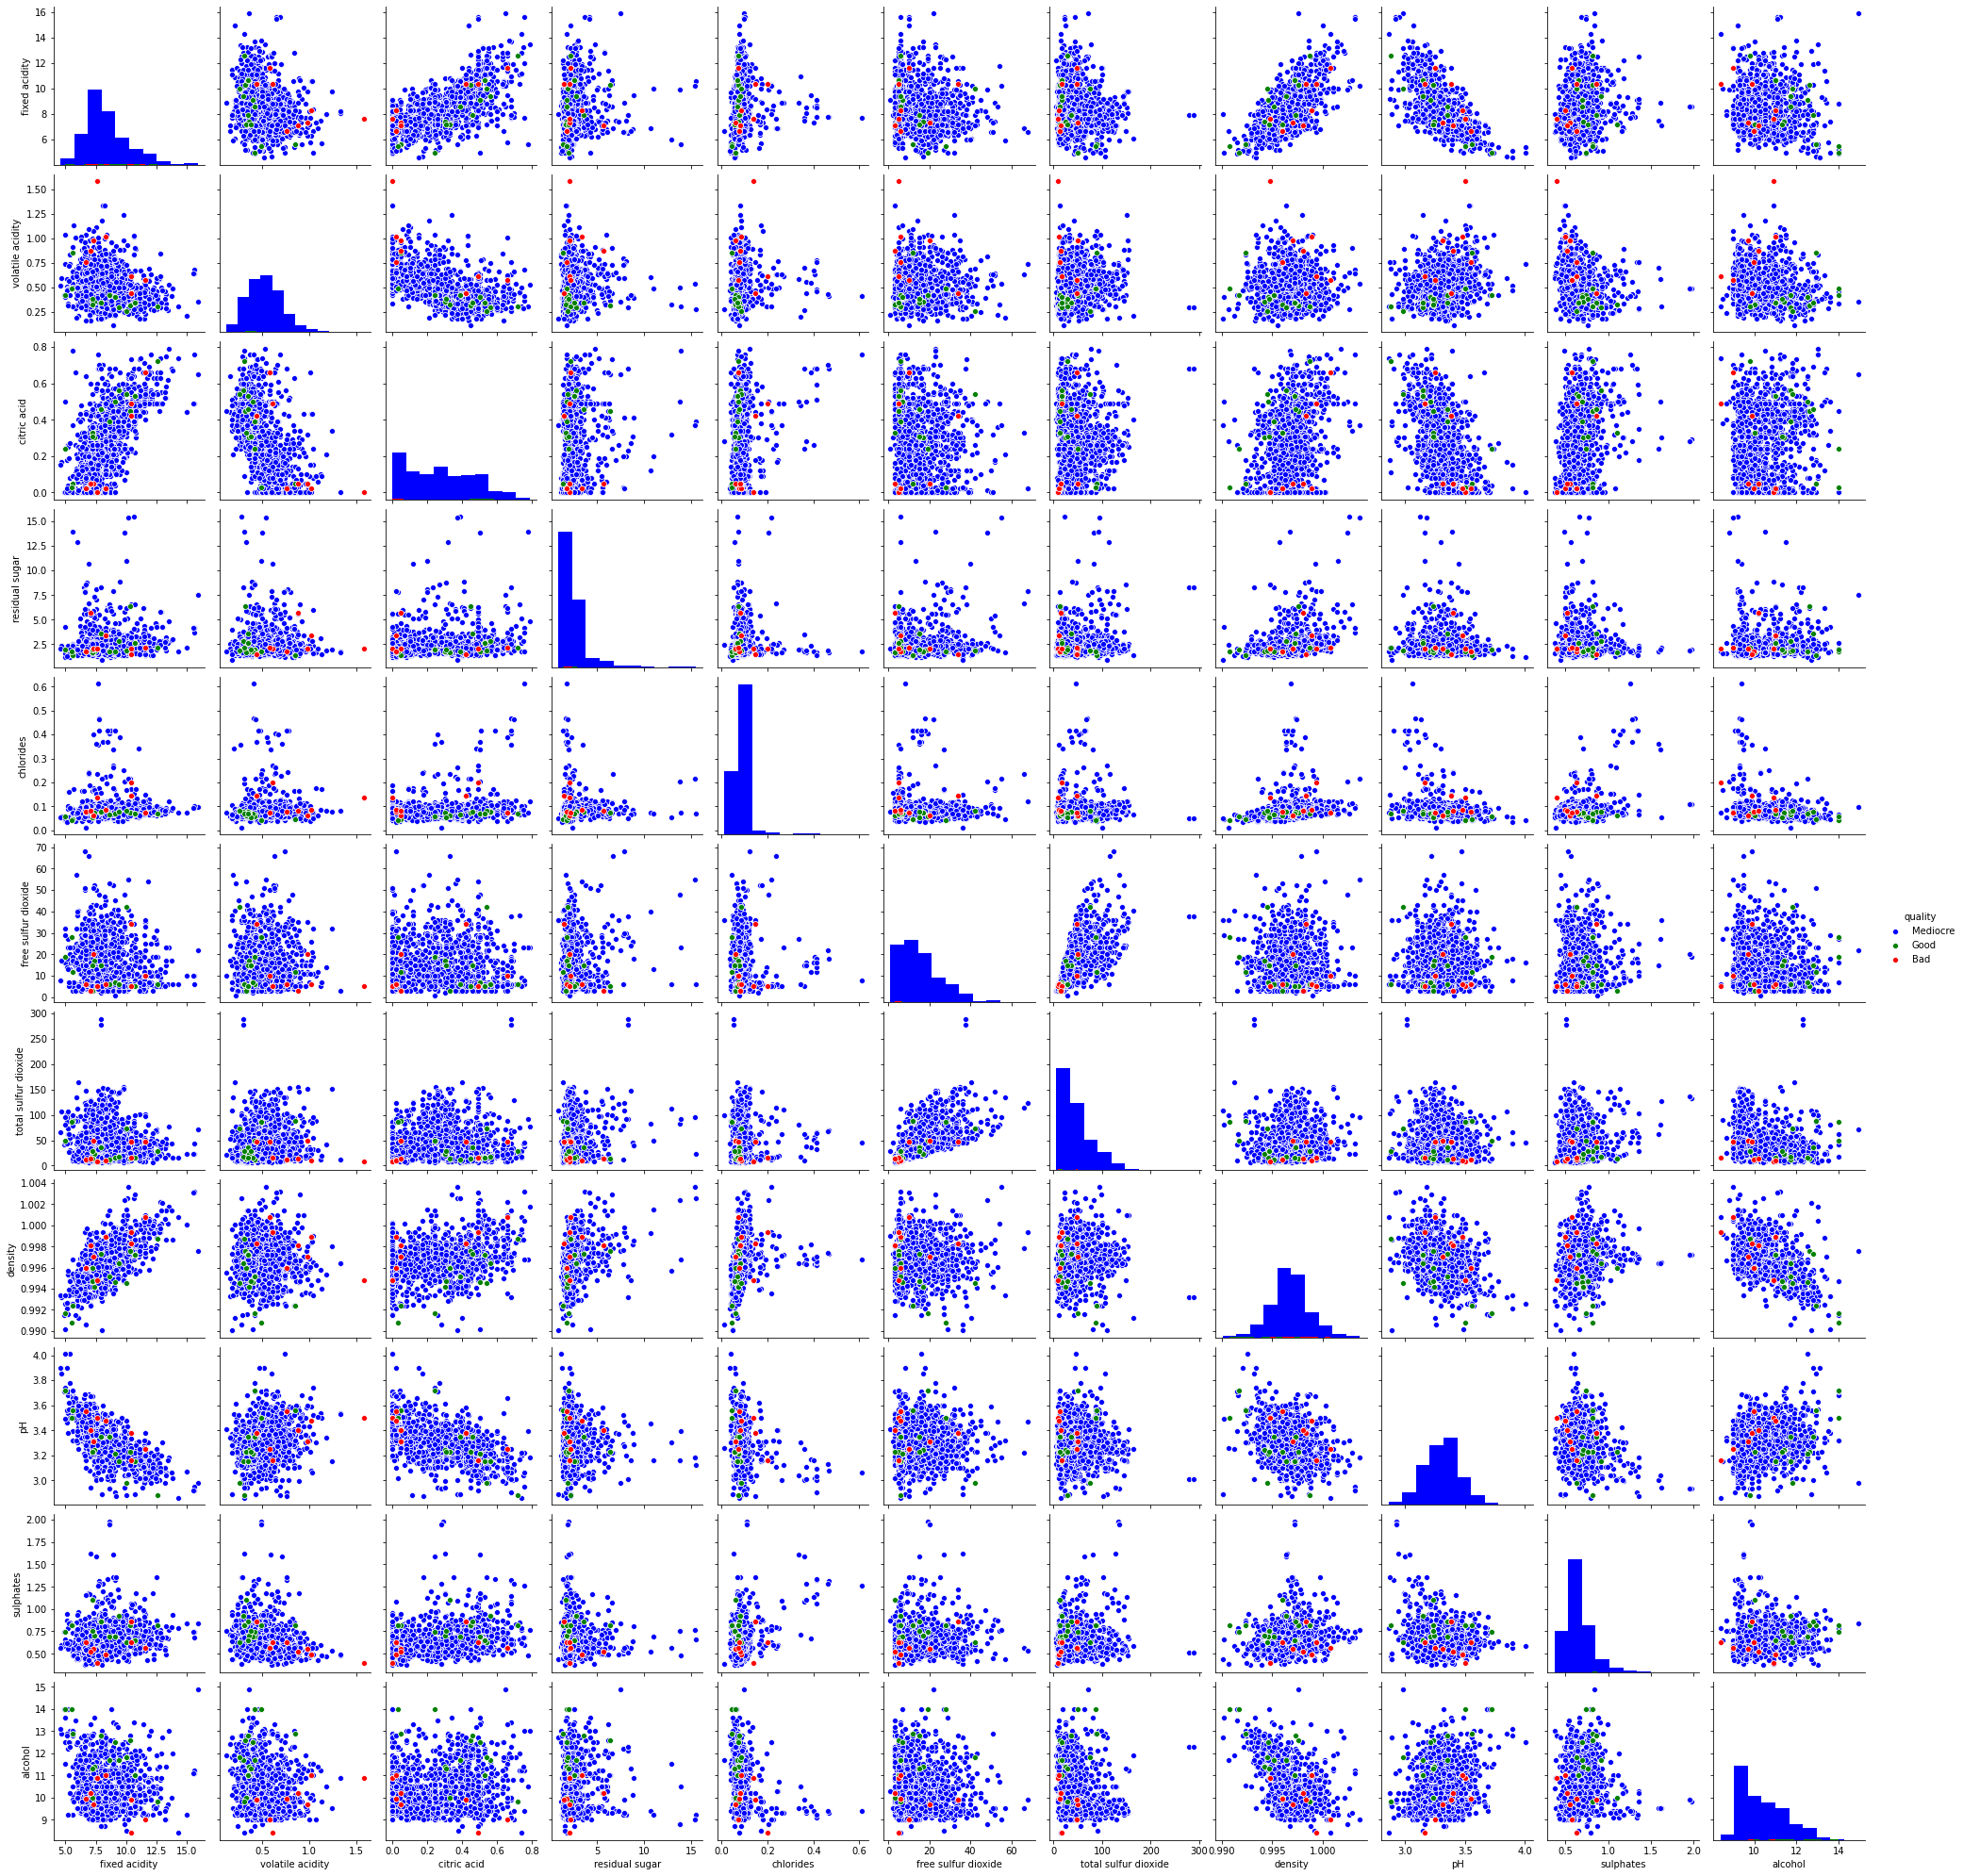

In [ ]:
sns.pairplot(tmp, hue='quality', diag_kind='hist', palette={'Bad': 'red', 'Mediocre': 'blue', 'Good': 'green'})

## Models

#### Evaluation

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
                     
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [ ]:
from sklearn import metrics

def print_report(pipe, data, labels):
    y_pred = pipe.predict(data)
    report = metrics.classification_report(labels, y_pred, zero_division=0)
    print(report)
    print("Accuracy: {:0.3f}".format(metrics.accuracy_score(labels, y_pred)))
  

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def evaluate(pipeline, name, data, labels):
  sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  plot_learning_curve(pipeline, name, data, labels, ylim=(0.2, 1.0), cv=sss)
  print_report(pipeline, data, labels)

### Logistic regression


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ('Scaler', StandardScaler()),
    # Set solver to lbfgs because it supports softmax regression,
    # Softmax regression in one-versus-all classification (multiclass)
    # Additionally, since this is multiclass problem, set multi_class to 'multinominal'
    ('LogReg', LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='multinominal'))
  ])

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_estimator(grid, name):
  print("Best parameters: ", grid.best_estimator_)
  print("Best Score for", name, ":", grid.best_score_)


def log_reg_gridsearch(pipe, X_train, y_train):
  log_reg_params = { 'LogReg__penalty': ['l1', 'l2'], 'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
  grid_log_reg = GridSearchCV(pipe, log_reg_params)
  grid_log_reg.fit(X_train, y_train)

  print_best_estimator(grid_log_reg, 'Logistic Regresssion')
  log_reg = grid_log_reg.best_estimator_
  return log_reg

In [ ]:
import warnings
warnings.filterwarnings('ignore')

logreg = log_reg_gridsearch(logreg, X_train, y_train)

Best parameters:  Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LogReg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score for Logistic Regresssion : 0.5871966911764706


              precision    recall  f1-score   support

           3       1.00      0.12      0.22         8
           4       0.33      0.02      0.04        42
           5       0.67      0.74      0.71       545
           6       0.55      0.61      0.58       510
           7       0.52      0.31      0.39       159
           8       0.00      0.00      0.00        15

    accuracy                           0.60      1279
   macro avg       0.51      0.30      0.32      1279
weighted avg       0.59      0.60      0.58      1279

Accuracy: 0.603


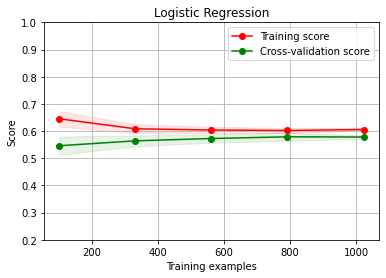

In [ ]:
evaluate(logreg, 'Logistic Regression', X_train, y_train)

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = Pipeline([
    ('Scaler', StandardScaler()),
    ('RandomForest', RandomForestClassifier())
  ])

In [ ]:
def rfc_gridsearch(pipeline, data, labels):
  parameters = {
      'n_estimators'      : [1, 10, 50, 100],
      'max_depth'         : [1, 5, 10, 15],
      'random_state'      : [0]
  }

  grid = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
  grid.fit(data, labels)
  print_best_estimator(grid, 'Random Forest Classifier')
  return grid.best_estimator_

In [ ]:
rfc = rfc_gridsearch(rfc, X_train, y_train)

Best parameters:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Score for Random Forest Classifier : 0.657561274509804


              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       1.00      0.98      0.99        42
           5       1.00      1.00      1.00       545
           6       1.00      1.00      1.00       510
           7       1.00      0.99      1.00       159
           8       1.00      1.00      1.00        15

    accuracy                           1.00      1279
   macro avg       1.00      0.99      1.00      1279
weighted avg       1.00      1.00      1.00      1279

Accuracy: 0.998


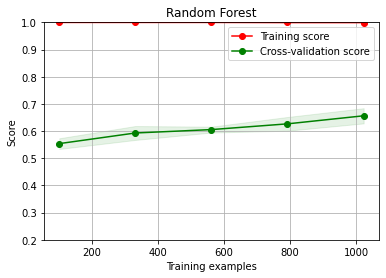

In [ ]:
evaluate(rfc, 'Random Forest', X_train, y_train)

### Final evaluation with test data


In [ ]:
y_pred = rfc.predict(X_test)
report = metrics.classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.79      0.76       136
           6       0.66      0.73      0.69       128
           7       0.72      0.57      0.64        40
           8       0.00      0.00      0.00         3

    accuracy                           0.70       320
   macro avg       0.35      0.35      0.35       320
weighted avg       0.66      0.70      0.68       320

